In [1]:
path = 'C:/Users/marco/UIC/4/2sem/TFG/INVIVO_DATA/CODE/data/no_train2'
path2 = 'C:/Users/marco/UIC/4/2sem/TFG/INVIVO_DATA/CODE/data/CNN_TRAINING_SESSIONS/Amigo2_1_hippo_2019-07-11_11-57-07_1150um'

In [3]:
liset = liset_tk(path, shank=2, downsample=4000, numSamples=1000000)

Downsampling data from 30000 Hz to 4000 Hz... Done!
Normalizing data... Done!
Shape of loaded data after downsampling and z-score:  (133333, 8)


In [4]:
import os
import numpy as np
from liset_aux import RAW2ORDERED
from load_data import downsample_data, z_score_normalization

channels = [i for i in range(8)]

filename = f"{path}/{[i for i in os.listdir(path) if i.endswith('.dat')][0]}"
file_len = os.path.getsize(filename=filename)
file_samples = file_len / 43 / 2

start = 0
numSamples = 10000000

if (numSamples + start) > file_len:
    numSamples = file_len - start
    
with open(filename, "rb") as f:
    # Put the reader at the starting index
    f.seek(start)

    if numSamples:
        raw = f.read(numSamples)
    else:
        raw = f.read(file_len - start)
    data = np.frombuffer(raw, dtype=np.int16)
    data = RAW2ORDERED(data, channels)


data = downsample_data(data, 30000, 4000)
data = z_score_normalization(data)

In [5]:
data.shape

(15504, 8)

In [6]:
liset.data = data

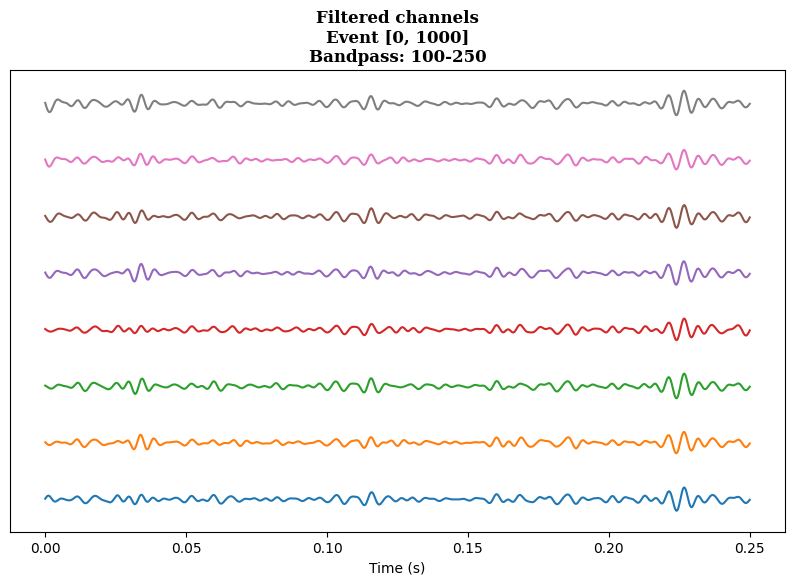

In [7]:
liset.plot_event([0, 1000], offset=6, filtered=[100, 250])

In [8]:
liset.load_model('../trainSNN/optimized_model/pytorchNetwork/256_128/E50_Y50/network.pt')

Loading model... 
Running on:  CPU
Done!


In [9]:
liset.predict()

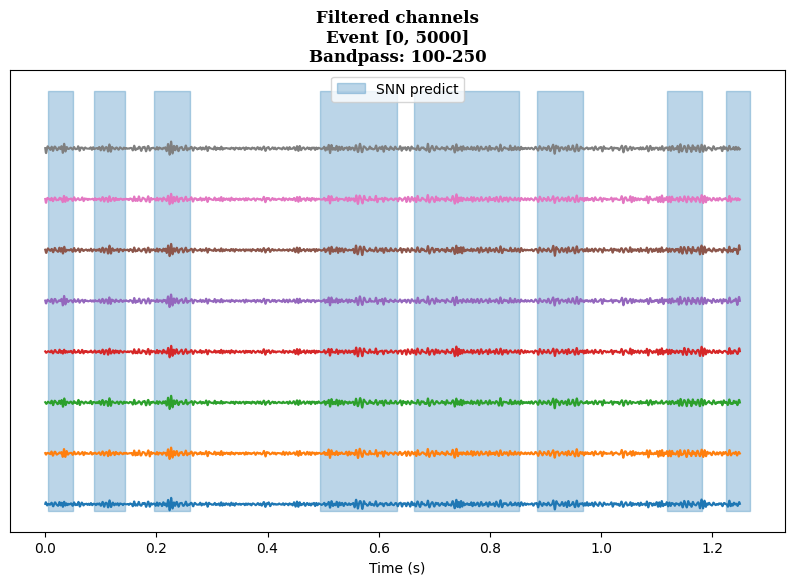

In [18]:
liset.plot_event([0, 5000], show_predictions=True, offset=10, filtered=[100, 250])

In [19]:
liset.prediction_idxs

array([[   18,   203],
       [  352,   571],
       [  786,  1044],
       [ 1977,  2533],
       [ 2652,  3413],
       [ 3539,  3874],
       [ 4477,  4729],
       [ 4898,  5071],
       [ 5346,  6517],
       [ 6602,  6919],
       [ 8293,  8504],
       [ 9380,  9592],
       [10075, 10322],
       [10975, 11196],
       [11213, 11412],
       [11438, 11658],
       [11712, 12013],
       [12038, 12434],
       [12438, 13214],
       [13259, 13503],
       [13722, 14253],
       [14352, 14649],
       [14665, 14830],
       [15033, 15423]])

In [2]:
###########################################################################################
#                                                                                         #
#                         Deloped by: Marcos Oriol Pagonabarraga                          #
#                           Contact: marcos.oriol.p@gmail.com                             #
#                                                                                         #
###########################################################################################

#
#  This module is developed for 3 main reasons:
#           - Loading correctly the data from liset labs (Instituto Cajal)
#           - Testing different models.
#           - Visualizing performance and data quality.
#
#

# Suppress warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import sys
sys.path.insert(0, '../utils/')
from eval import modelEval
sys.path.insert(0, '../runSNN/')
from models import torchSNN

import tensorflow as tf
import tensorflow.keras as kr

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from copy import deepcopy
from format_predictions import get_predictions_indexes
from liset_aux import *
from load_data import *
from signal_aid import *




class liset_tk():
    """
    Class for handling data processing and visualization related to ripple events.

    Parameters:
    - data_path (str): Path to the directory containing the data.
    - shank (int): Shank of the electrode.
    - downsample (bool, optional): Whether to downsample the data. Default is False.
    - normalize (bool, optional): Whether to normalize the data. Default is True.
    - numSamples (int, optional): Number of samples. Default is False.
    - verbose (bool, optional): Whether to display verbose output. Default is True.
    """
     
    def __init__(self, data_path, shank, downsample = False, normalize = True, numSamples = False, start = 0, verbose=True, original_fs=30000):

        # Set the verbose
        self.verbose = verbose
        self.numSamples = numSamples
        self.start = start
        self.original_fs = original_fs
        if downsample:
            self.downsampled_fs = downsample
            self.fs_conv_fact = self.original_fs/self.downsampled_fs
        else:
            self.fs_conv_fact = 1

        # Initialize class variables.
        self.prediction_times = []
        self.model = None
        self.default_config_chans = np.array([[25],[21],[24],[28],[26],[22],[23],[27],[29],[17],[20],[32],[30],[18],[19],[31],[16],[ 4],[ 1],[13],[15],[ 3],[ 2],[14],[12],[ 8],[ 5],[ 9],[11],[ 7],[ 6],[10],[33],[34],[35],[36],[37],[38],[39],[40],[41],[42],[43]], dtype='uint8')

        
        # Load the data.
        self.load(data_path, shank, downsample = downsample, normalize=normalize)

        # Try to load the ripples if the path contain a file with ripple times.
        # Only load ripples in the interval selected of data (chunk)
        if hasattr(self, 'fs'):
            if 'mapsCh.csv' in os.listdir(data_path):
                ripples = (load_ripples(path)[:, [0,2]])
                self.ripples_GT = self.ripples_in_chunk(ripples / self.original_fs, start, numSamples, self.fs, self.fs_conv_fact)
                self.ripples_GT = (self.ripples_GT * self.fs - start / self.fs_conv_fact).astype(int)
            else:
                self.ripples_GT = self.ripples_in_chunk(load_ripple_times(data_path), start, numSamples, self.fs, self.fs_conv_fact)
            
                if type(self.ripples_GT) is np.ndarray:
                    self.num_ripples = len(self.ripples_GT)
                    self.ripples_GT = (self.ripples_GT * self.fs - start / self.fs_conv_fact).astype(int)


    @plain_plot
    @hide_y_ticks_on_offset
    def plot_event(self, 
                   event, 
                   offset=0, 
                   extend=0, 
                   delimiter=False, 
                   show=True, 
                   filtered=[], 
                   title='', 
                   label='', 
                   ch=False,
                   ylim=False,
                   line_color=False,
                   show_ground_truth=False, 
                   show_predictions=False, 
                   plain=False):
        """
        Plot the ripple signal number idx.

        Parameters:
        - idx (int): Index of the ripple to plot.
        - offset (float): Offset between channels for visualization.
        - extend (float): Extend the plotted time range before and after the ripple.
        - delimiter (bool): Whether to highlight the ripple area.

        Returns:
        - fig (matplotlib.figure.Figure): The generated figure.
        - ax (matplotlib.axes.Axes): The axes object containing the plot.
        """
            
        prop = self.fs_conv_fact
        interval = deepcopy(event)
        handles = []
        labels = []

        try:
            if extend != 0:
                if (interval[0] - extend) < 0:
                    interval[0] = int(self.start / prop)
                else:
                    interval[0] = interval[0] - extend

                if (interval[1] + extend) > self.numSamples/prop:
                    interval[1] = int((self.start + self.numSamples)/prop)
                else:
                    interval[1] = interval[1] + extend

        except IndexError:
            print('IndexError')
            print(f'There no data available for the selected samples.\nLength of loaded data: {int(self.numSamples/self.fs_conv_fact)}')
            return None, None

        # Define window data
        self.window_interval = interval
        mask = (self.ripples_GT[:, 1] >= interval[0]) & (self.ripples_GT[:, 0] <= interval[1])
        self.window_ripples = self.ripples_GT[mask]

        interval_data = self.data[interval[0]: interval[1]][:]
        self.window = deepcopy(interval_data)
        
        time_vector = np.linspace(interval[0] / self.fs, interval[1] / self.fs, interval_data.shape[0])
        if show:
            fig, ax = plt.subplots(figsize=(10, 6))
        for i, chann in enumerate(interval_data.transpose()):
            if filtered:
                bandpass = filtered
                chann = bandpass_filter(chann, bandpass, self.fs)
                self.window[:, i] = chann
            if show:
                if ch:
                    if i in ch:
                        if line_color:
                            ax.plot(time_vector, chann + i * offset, line_color)
                        else:
                            ax.plot(time_vector, chann + i * offset)
                else:
                    if line_color:
                        ax.plot(time_vector, chann + i * offset, line_color)
                    else:
                        ax.plot(time_vector, chann + i * offset)
            
            if ylim:
                ax.set_ylim(ylim)
                

        max_val = np.max(self.window.reshape((self.window.shape[0]*self.window.shape[1]))) + offset*8
        min_val = np.min(self.window.reshape((self.window.shape[0]*self.window.shape[1])))

        if delimiter and show:
            if extend > 0:
                ripple_area = [time_vector[round(extend)], time_vector[-round(extend)]]
                if not label:
                    label='Event area'
                fill_DEL = ax.fill_between(ripple_area, min_val, max_val, color="tab:blue", alpha=0.2)
                handles.append(fill_DEL)
                labels.append(label)
            else:
                if self.verbose:
                    print('Delimiter not applied because there is no extend.')

        if show_ground_truth:
            if hasattr(self.ripples_GT, 'dtype'):
                for ripple in self.window_ripples:
                    fill_GT = ax.fill_between([ripple[0] / self.fs, ripple[1] / self.fs],  min_val, max_val, color="tab:red", alpha=0.3)

            if 'fill_GT' in locals():
                handles.append(fill_GT)
                labels.append('Ground truth' if not label else label)

        if show_predictions:
            if hasattr(self, 'prediction_idxs'):
                mask = (self.prediction_idxs[:, 1] >= interval[0]) & (self.prediction_idxs[:, 0] <= interval[1])
                self.prediction_times_from_window = self.prediction_times[mask]
                for times in self.prediction_times_from_window:
                    fill_PRED = ax.fill_between([times[0], times[1]], min_val, max_val, color="tab:blue", alpha=0.3)

            if 'fill_PRED' in locals():
                handles.append(fill_PRED)
                labels.append(f'{self.model_type} predict')

        # Figure styles
        if filtered and not title:
            title = f'Filtered channels\nEvent {interval}\nBandpass: {bandpass[0]}-{bandpass[1]}'
        if not title:
            title = f'Channels for samples {interval}'

        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude (mV)')
        if not len(handles) == 0:        
            ax.legend(handles, labels)

        text = ax.set_title(title, loc='center', fontfamily='serif', fontsize=12, fontweight='bold')
        ax.grid(True)
        self.fig = fig
        self.ax = ax

        if show:
            return fig, ax
        
    
    def load_predictions(self, preds):
        if not isinstance(preds, np.ndarray):
            preds = np.array(preds)
        if np.mean(preds[1] - preds[0]) < 1:
            conv_fact = 1
            self.prediction_times = preds
            self.prediction_idxs = (preds * self.fs).astype(int)
        else:
            conv_fact = self.fs
            self.predition_idxs = preds
            self.prediction_times = preds / self.fs

        if hasattr(self, "window_interval"):
            mask = (preds[:, 1] >= self.window_interval[0] / conv_fact) & (preds[:, 0] <= self.window_interval[1] / conv_fact)
            self.prediction_times_from_window = preds[mask]
        

    def ripples_in_chunk(self, ripples, start, numSamples, fs, prop):
        if not numSamples:
            numSamples = self.file_samples - self.start

        in_chunk = ripples[(ripples[:,0] > start/prop/fs) & (ripples[:,0] < (start + numSamples)/prop/fs)]

        return in_chunk


    def load_dat(self, path, channels, numSamples = False):
        """
        Load data from a .dat file.

        Parameters:
        - path (str): Path to the directory containing the .dat file.
        - channels (list): List of channel IDs to load.
        - numSamples (int, optional): Number of samples to load. Default is False (load all samples).
        - sampleSize (int, optional): Size of each sample in bytes. Default is 2.
        - verbose (bool, optional): Whether to display verbose output. Default is False.

        Returns:
        - data (numpy.ndarray): Loaded data as a NumPy array.
        """

        try:
            filename = f"{path}/{[i for i in os.listdir(path) if i.endswith('.dat')][0]}"
            self.file_len = os.path.getsize(filename=filename)
            self.file_samples = self.file_len / 43 / 2
        except:
            if self.verbose:
                print('.dat file not in path')
            return False
        
        start = self.start * 43 * 2
        numSamples = self.numSamples * 43 * 2

        if start > self.file_len:
            if self.verbose:
                print(f'the start must be lower than the total file samples.\nTotal file samples: {self.file_samples}')
            return False
        if (numSamples + start) > self.file_len:
            numSamples = self.file_len - start


        if (self.file_len < numSamples) or ((numSamples + self.start) > self.file_len):
            if self.verbose:
                print(f'file has only {self.file_samples} samples')
            return False
            
        with open(filename, "rb") as f:
            # Put the reader at the starting index
            f.seek(start)

            if numSamples:
                raw = f.read(numSamples)
            else:
                raw = f.read(self.file_len - self.start)
            data = np.frombuffer(raw, dtype=np.int16)
            data = RAW2ORDERED(data, channels)
            return data
            

    def load(self, data_path, shank, downsample, normalize):
        """
        Load all, optionally downsample and normalize it.

        Parameters:
        - data_path (str): Path to the data directory.
        - shank (int): Shank of the electrode.
        - downsample (float): Downsample factor.
        - normalize (bool): Whether to normalize the data.
    
        Returns:
        - data (numpy.ndarray): Loaded and processed data.
        """

        if 'mapsCh.csv' in os.listdir(data_path):
            try:
                # channels = load_channels(data_path, shank)
                channels = self.default_config_chans[8 * (shank -1):8 * shank]
            except:
                print(f'No channels available for shank {shank}')
                return
        else:
            try:
                info = loadmat(f'{data_path}/info.mat')
            except:
                print('Info file as "info.mat" not found.')
                return
                
            try:
                channels = info['neurosparkmat']['channels'][0][0][8 * (shank -1):8 * shank]
            except Exception as err:
                print(f'No data available for shank {shank}\n\n{err}')
                return 

        
        raw_data = self.load_dat(data_path, channels, numSamples=self.numSamples)
        if hasattr(raw_data, 'shape'):
            self.data = self.clean(raw_data, downsample, normalize)
            self.duration = self.data.shape[0]/self.fs


    def clean(self, data, downsample, normalize):
        """
        Clean the loaded data by downsampling and normalizing it.

        Parameters:
        - data (numpy.ndarray): Raw data to be cleaned.
        - downsample (bool): Whether to downsample the data.
        - normalize (bool): Whether to normalize the data.

        Returns:
        - data (numpy.ndarray): Cleaned data after downsampling and normalization.
        """

        if downsample:
            self.fs = self.downsampled_fs
            # Downsample data
            if self.verbose:
                print("Downsampling data from %d Hz to %d Hz..."%(self.original_fs, self.downsampled_fs), end=" ")
            data = downsample_data(data, self.original_fs, self.downsampled_fs)
            if self.verbose:
                print("Done!")

            if normalize:
                # Normalize it with z-score
                if self.verbose:
                    print("Normalizing data...", end=" ")
                data = z_score_normalization(data)
                if self.verbose:
                    print("Done!")
                    print("Shape of loaded data after downsampling and z-score: ", np.shape(data))
        else:
            self.fs = self.original_fs

        return data


    def load_model(self, model_path, y_samples=50):
        """
        Load a trained tf.keras model from the specified path.

        Parameters:
        - model_path (str): Path to the saved model file.

        Returns:
        - None
        """
        if self.verbose:
            print("Loading model...", end=" ")

        if model_path.endswith('.pt'):
            sys.path.insert(0, '../trainSNN')
            self.model = torchSNN(model_path)
            self.model_type='SNN'

        else:
            optimizer = kr.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
            model = kr.models.load_model(model_path, compile=False)
            model.compile(loss="binary_crossentropy", optimizer=optimizer)
            self.model = model
            self.model_type = 'CNN'

            # Try to get the input shape of the model, otherwise most probable is 0.0128.
            try:
                self.model_window_for_input = self.model.input_shape[1] / self.fs
            except:
                self.model_window_for_input = 0.0128

        if self.verbose:
            print("\nRunning on: ", "CPU" if not tf.config.experimental.list_physical_devices('GPU') else "GPU")
            print("Done!")



    def predict(self, threshold = 0.7, channel=5):
        """
        Predict events in the data using the loaded model.

        Parameters:
        - threshold (float, optional): Threshold for event prediction confidence. Default is 0.7.

        Returns:
        - None
        """
        if self.model_type == 'SNN':
            input = y_discretize_1Dsignal(bandpass_filter(self.data[:, channel], [100, 250], self.fs), 50)
            output = self.model(input)
            self.prediction_idxs = detect_rate_increase(output)
            self.prediction_times = self.prediction_idxs / self.fs

        elif self.model_type == 'CNN':
            window = self.model_window_for_input
            X = generate_overlapping_windows(self.data, window, window/2, self.fs)
            raw_predictions = self.model.predict(X, verbose=self.verbose)
            self.prediction_idxs = merge_overlapping_intervals(get_predictions_indexes(raw_predictions, window, window/2, self.fs, threshold))
            self.prediction_times = self.prediction_idxs / self.fs

        else:
            print('No model loaded.')
            return
        

    def evaluate(self, preds=None, chart=True, model_type=''):
        """
        Evaluate the performance of the model on the loaded data.

        Parameters:
        - threshold (float, optional): Threshold for event prediction confidence. Default is 0.7.

        Returns:
        - None
        """
        validate = modelEval(self.ripples_GT, self.model_type if model_type == '' else model_type)
        if hasattr(self, 'prediction_idxs') and preds is None:
            validate(self.prediction_idxs, chart=chart)
        elif preds is not None:
            validate(preds, chart=chart)
        else:
            print('No predictions available.')

    
    def savefig(self, fname, background=False):
        if fname.endswith('.svg'):
            self.fig.savefig(fname, transparent=not background, format='svg', bbox_inches='tight')
        else:
            self.fig.savefig(fname, transparent=not background, bbox_inches='tight')